In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The full list of all the datasets stored inside torchvision.dataseets is [here](https://pytorch.org/vision/stable/datasets.html)

# Tensors

Tensors are just like multidimensional vectors, whose computations can also be prfomred on GPU and specially made TPUs. They are the most widely used data-sturctures in Deep learning.

In [2]:
import torch
import numpy as np

### Tensors intialization

Directly from data

In [3]:
data = [[1,2], [3,4]]
x_data = torch.tensor(data)

From numpy array

In [4]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

From other tensor

In [5]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.7955, 0.8620],
        [0.1990, 0.7944]]) 



With random or constant values

Where you’ll want some assurance of the reproducibility of your results. Manually setting your random number generator’s seed is the way to do this. Seeding basically fixes the randomly generated value for the desired instance

In [6]:
torch.manual_seed(1729)
random_tensor = torch.rand(2, 3)
print(random_tensor)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])


In [7]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

new_tensor = torch.rand_like(ones_tensor)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")
print(f"New Tensor: \n {new_tensor}")

Random Tensor: 
 tensor([[0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])
New Tensor: 
 tensor([[0.6128, 0.1519, 0.0453],
        [0.5035, 0.9978, 0.3884]])


### Operations on tensor

In [8]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## Full list - https://pytorch.org/docs/stable/torch.html

Slicing and indexing

In [9]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")

tensor[:,1] = 0

print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


### Joining the tensors

In [10]:
t1 = torch.ones(3,3)
t2 = torch.zeros(3,4)
t3 = torch.cat([t1, t2], dim=1)
t3

tensor([[1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.]])

In [11]:
t4 = torch.ones(3,4)
t5 = torch.stack([t2, t4], dim=0)
t5

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

### Arithmatic Opearations

Multiplication

In [12]:
t5 = torch.rand(3, 3)
multi1 = t1 @ t5.T
multi2 = t1.matmul(t5.T)
multi3 = torch.rand_like(t1)
torch.matmul(t1, t5.T, out=multi3)

print(multi1)
print(multi2)
print(multi3)

tensor([[1.5258, 0.7665, 1.7158],
        [1.5258, 0.7665, 1.7158],
        [1.5258, 0.7665, 1.7158]])
tensor([[1.5258, 0.7665, 1.7158],
        [1.5258, 0.7665, 1.7158],
        [1.5258, 0.7665, 1.7158]])
tensor([[1.5258, 0.7665, 1.7158],
        [1.5258, 0.7665, 1.7158],
        [1.5258, 0.7665, 1.7158]])


Sum

In [13]:
agg = t5.sum()
agg_item = agg.item()

print(agg)
print(agg_item)

tensor(4.0081)
4.008126258850098


In-place operations Operations that store the result into the operand are called in-place. They are denoted by a _ suffix. For example: x.copy_(y), x.t_(), will change x.

In [14]:
t5.add_(3)
t5

tensor([[3.0703, 3.5105, 3.9451],
        [3.2359, 3.1979, 3.3327],
        [3.6146, 3.5999, 3.5013]])

In [15]:
t7 = t5 + 3
t7

tensor([[6.0703, 6.5105, 6.9451],
        [6.2359, 6.1979, 6.3327],
        [6.6146, 6.5999, 6.5013]])

Tensors supports almost all mathematical operations

In [16]:
import math

In [17]:
# common functions
a = torch.rand(2, 4) * 2 - 1
print('Common functions:')
print(torch.abs(a))
print(torch.ceil(a))
print(torch.floor(a))
print(torch.clamp(a, -0.5, 0.5))

# trigonometric functions and their inverses
angles = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
sines = torch.sin(angles)
inverses = torch.asin(sines)
print('\nSine and arcsine:')
print(angles)
print(sines)
print(inverses)

# bitwise operations
print('\nBitwise XOR:')
b = torch.tensor([1, 5, 11])
c = torch.tensor([2, 7, 10])
print(torch.bitwise_xor(b, c))

# comparisons:
print('\nBroadcasted, element-wise equality comparison:')
d = torch.tensor([[1., 2.], [3., 4.]])
e = torch.ones(1, 2)  # many comparison ops support broadcasting!
print(torch.eq(d, e)) # returns a tensor of type bool

# reductions:
print('\nReduction ops:')
print(torch.max(d))        # returns a single-element tensor
print(torch.max(d).item()) # extracts the value from the returned tensor
print(torch.mean(d))       # average
print(torch.std(d))        # standard deviation
print(torch.prod(d))       # product of all numbers
print(torch.unique(torch.tensor([1, 2, 1, 2, 1, 2]))) # filter unique elements

# vector and linear algebra operations
v1 = torch.tensor([1., 0., 0.])         # x unit vector
v2 = torch.tensor([0., 1., 0.])         # y unit vector
m1 = torch.rand(2, 2)                   # random matrix
m2 = torch.tensor([[3., 0.], [0., 3.]]) # three times identity matrix

print('\nVectors & Matrices:')
print(torch.cross(v2, v1)) # negative of z unit vector (v1 x v2 == -v2 x v1)
print(m1)
m3 = torch.matmul(m1, m2)
print(m3)                  # 3 times m1
print(torch.svd(m3))       # singular value decomposition

Common functions:
tensor([[0.5951, 0.1461, 0.4382, 0.1866],
        [0.4602, 0.2551, 0.4715, 0.9238]])
tensor([[-0., 1., 1., -0.],
        [1., 1., 1., -0.]])
tensor([[-1.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.]])
tensor([[-0.5000,  0.1461,  0.4382, -0.1866],
        [ 0.4602,  0.2551,  0.4715, -0.5000]])

Sine and arcsine:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7854, 1.5708, 0.7854])

Bitwise XOR:
tensor([3, 2, 1])

Broadcasted, element-wise equality comparison:
tensor([[ True, False],
        [False, False]])

Reduction ops:
tensor(4.)
4.0
tensor(2.5000)
tensor(1.2910)
tensor(24.)
tensor([1, 2])

Vectors & Matrices:
tensor([ 0.,  0., -1.])
tensor([[0.2138, 0.5395],
        [0.3686, 0.4007]])
tensor([[0.6414, 1.6186],
        [1.1057, 1.2021]])
torch.return_types.svd(
U=tensor([[-0.7309, -0.6825],
        [-0.6825,  0.7309]]),
S=tensor([2.3475, 0.4339]),
V=tensor([[-0.5212,  0.8535],
        [-0.8535, -0.5212]]))


Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

### Squeeze and Unsqueeze

One case where you might need to change the number of dimensions is passing a single instance of input to your model. PyTorch models generally expect batches of input.

For example, imagine having a model that works on 3 x 226 x 226 images - a 226-pixel square with 3 color channels. When you load and transform it, you’ll get a tensor of shape (3, 226, 226). Your model, though, is expecting input of shape (N, 3, 226, 226), where N is the number of images in the batch. So how do you make a batch of one?

The unsqueeze() method adds a dimension of extent 1. unsqueeze(0) adds it as a new zeroth dimension - now you have a batch of one!

In [18]:
a = torch.rand(3, 226, 226)
b = a.unsqueeze(0)
c = b.squeeze(0)

print(a.shape)
print(b.shape)
print(c.shape)

torch.Size([3, 226, 226])
torch.Size([1, 3, 226, 226])
torch.Size([3, 226, 226])


So if that’s unsqueezing? What do we mean by squeezing? We’re taking advantage of the fact that any dimension of extent 1 does not change the number of elements in the tensor.



In [19]:
c = torch.rand(1, 1, 1, 1, 1)
print(c)

tensor([[[[[0.8083]]]]])


# GPU and TPUs


As we discussed before, tensor operations can be performed on GPU and TPUs faster compare to CPU. Let's check if we have a supporting GPU or not.

In [20]:
if torch.cuda.is_available():
    print('We have a GPU!')
else:
    print('Sorry, CPU only.')

Sorry, CPU only.


* By default, new tensors are created on the CPU, so we have to specify when we want to create our tensor on the GPU with the optional device argument. You can see when we print the new tensor, PyTorch informs us which device it’s on (if it’s not on CPU).

* You can query the number of GPUs with torch.cuda.device_count(). If you have more than one GPU, you can specify them by index: device='cuda:0', device='cuda:1', etc.

* As a coding practice, specifying our devices everywhere with string constants is pretty fragile. In an ideal world, your code would perform robustly whether you’re on CPU or GPU hardware. You can do this by creating a device handle that can be passed to your tensors instead of a string:

In [21]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

x = torch.rand(2, 2, device=my_device)
print(x)

Device: cpu
tensor([[0.5408, 0.2576],
        [0.5258, 0.5329]])


If you have an existing tensor living on one device, you can move it to another with the to() method. The following line of code creates a tensor on CPU, and moves it to whichever device handle you acquired in the previous cell.



In [22]:
y = torch.rand(2, 2)
y = y.to(my_device)

# Datasets and Dataloaders

### Loading dataset

In [23]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [24]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Visualizing dataset

In [25]:
import pandas as pd

In [26]:
# for i, j in training_data:
#     print(j)

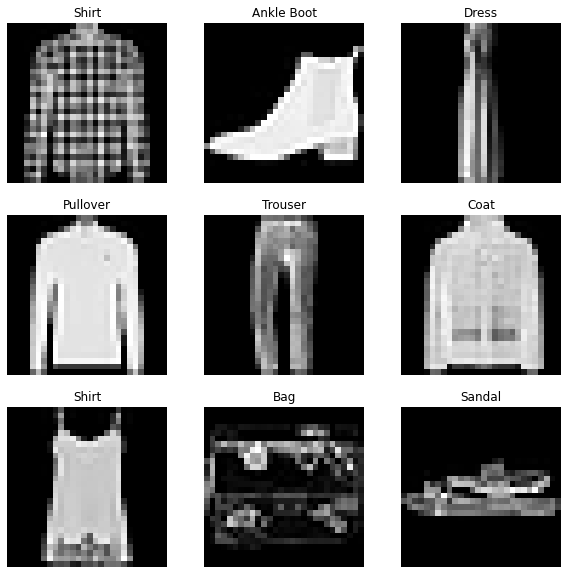

In [27]:
labels_map = {0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",}

figure = plt.figure(figsize = (10,10))
cols ,rows = 3, 3

for i in range (1, rows*cols+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Custom dataset

In [28]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Preparing your data for training with DataLoaders

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through dataset

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


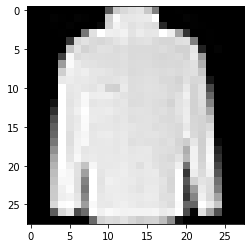

Label: 4


In [30]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#### For further reading - https://pytorch.org/docs/stable/data.html

# Transform for data manipulation

All TorchVision datasets have two parameters -transform to modify the features and target_transform to modify the labels - that accept callables containing the transformation logic. 

In [31]:
import torch 
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [32]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()

ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.], 

Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.


#### For further info - https://pytorch.org/vision/stable/transforms.html

# Autograd 

Autograd helps in computing loss function, applying optimization and change values of weights and biases to keep the loss min.

In [33]:
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

Next, we’ll create an input tensor full of evenly spaced values on the interval [0,2π], and specify requires_grad=True

In [34]:
a = torch.linspace(0, 2*math.pi, steps = 25, requires_grad=True)
a

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)

Next, we’ll perform a computation, and plot its output in terms of its inputs:

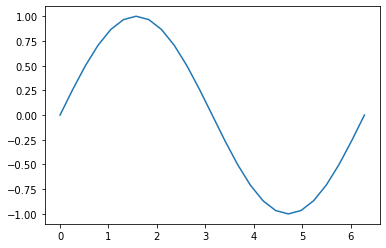

In [35]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

# Building a simple Neural Network

In [36]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [38]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [40]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [41]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3])


## Backpropagation

Here the different matrices are - x input , w weight, b bias and y output

Since w and b are the one who need to be optimized, they have requires_grad = True

Loss function used here is Cross entropy

In [42]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
loss

tensor(0.6843, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

A function that we apply to tensors to construct computational graph is in fact an object of class Function. This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. You can find more information of Function in the documentation - https://pytorch.org/docs/stable/autograd.html#function

In [43]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7efd05834450>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7efd05834410>


Computing gradients

In [44]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1740, 0.0236, 0.2370],
        [0.1740, 0.0236, 0.2370],
        [0.1740, 0.0236, 0.2370],
        [0.1740, 0.0236, 0.2370],
        [0.1740, 0.0236, 0.2370]])
tensor([0.1740, 0.0236, 0.2370])


We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

Disabling gradient tracking with no_grad() and detach()

In [45]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

True
False
False


There are reasons you might want to disable gradient tracking:

* To mark some parameters in your neural network as frozen parameters. This is a very common scenario for finetuning a pretrained network

* To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.



In many cases, we have a scalar loss function, and we need to compute the gradient with respect to some parameters. However, there are cases when the output function is an arbitrary tensor. In this case, PyTorch allows you to compute so-called Jacobian product, and not the actual gradient.

In [46]:
inp = torch.eye(5, requires_grad=True)
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


### Optimzing model parameters

In [47]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Loss function

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.


In [48]:
loss_fn = nn.CrossEntropyLoss()

Optimizer

PyTorch suppoort all commonly used optimizersa like ADAM and RMSProp, we are using Stochastic Gradient Descent here

In [49]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

* Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

* Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

* Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

Full Implementation

In [50]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [51]:
for t in range(epochs):
    print(f"epoch {t+1}\n...........")
    train_loop(train_dataloader, model,  loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done")

epoch 1
...........
loss: 2.310282  [    0/60000]
loss: 2.291119  [ 6400/60000]
loss: 2.278934  [12800/60000]
loss: 2.274889  [19200/60000]
loss: 2.262816  [25600/60000]
loss: 2.241260  [32000/60000]
loss: 2.241848  [38400/60000]
loss: 2.215348  [44800/60000]
loss: 2.210773  [51200/60000]
loss: 2.192896  [57600/60000]
Test Error: 
 Accuracy: 51.4%, Avg loss: 2.177980 

epoch 2
...........
loss: 2.190925  [    0/60000]
loss: 2.171754  [ 6400/60000]
loss: 2.123956  [12800/60000]
loss: 2.143089  [19200/60000]
loss: 2.095096  [25600/60000]
loss: 2.045029  [32000/60000]
loss: 2.077874  [38400/60000]
loss: 2.001703  [44800/60000]
loss: 2.006702  [51200/60000]
loss: 1.955378  [57600/60000]
Test Error: 
 Accuracy: 52.1%, Avg loss: 1.936294 

epoch 3
...........
loss: 1.971099  [    0/60000]
loss: 1.931441  [ 6400/60000]
loss: 1.821588  [12800/60000]
loss: 1.874078  [19200/60000]
loss: 1.753956  [25600/60000]
loss: 1.705917  [32000/60000]
loss: 1.745489  [38400/60000]
loss: 1.634481  [44800/600

### Using pretrained model

You probably should have heard about vgg16 model, its a CNN classifier model which can classify input image into 1000 different categories. Let's use it here.

In [52]:
import torchvision.models as models

Saving the model

In [53]:
model = models.vgg16(pretrained = True)
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading the model

In [54]:
model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1